In [1]:
import numpy as np
import pandas as pd

In [60]:
df_mip = pd.read_excel("MIP.xlsx", sheet_name="Matrix_MIP", index_col=0)
df_mct = pd.read_excel("MIP.xlsx", sheet_name="Matrix_MCT", index_col=0)
df_total = pd.read_excel("MIP.xlsx", sheet_name="Total")
sector_names = df_mip.columns
sector_clave = ["Cría de ganado, otros animales; productos animales; y actividades de apoyo", 
                "Acuicultura y pesca de camarón", 
                "Extracción de petróleo crudo y gas natural",
                "Producción de madera y de productos de madera",
                "Fabricación de metales comunes",
                "Fabricación de maquinaria y equipo",
                "Generación, captación y distribución de energía eléctrica",
                "Financiación de planes de seguro, excepto seguridad social"]
df_sales = pd.read_excel("tasa_crecimiento.xlsx")

In [71]:
df_sector = pd.DataFrame([df_mip.columns]).T
df_sector.columns = ["nombresector"]
df_sector["ones"] = 1
df_sector

,nombresector,ones
0,"Cultivo de banano, café y cacao",1
1,Cultivo de cereales,1
2,Cultivo de flores,1
3,"Cultivo de tubérculos, vegetales, melones y fr...",1
4,Cultivo oleaginosas e industriales,1
...,...,...
66,Servicios de enseñanza público (no de mercado),1
67,Servicios sociales y de salud privado,1
68,Servicios sociales y de salud no de mercado,1
69,Servicios de asociaciones; esparcimiento; cult...,1


# Shock 1

In [72]:
df = df_sales[["nombresector", "salesgrowth"]].iloc[:6]
df_sector = pd.merge(df_sector, df, how="outer", on="nombresector").fillna(0)
df_sector["p0"] = df_sector["ones"] + df_sector["salesgrowth"]   #.to_csv("que_paso.csv")
df_sector

,nombresector,ones,salesgrowth,p0
0,"Cultivo de banano, café y cacao",1,0.0,1.0
1,Cultivo de cereales,1,0.0,1.0
2,Cultivo de flores,1,0.0,1.0
3,"Cultivo de tubérculos, vegetales, melones y fr...",1,0.0,1.0
4,Cultivo oleaginosas e industriales,1,0.0,1.0
...,...,...,...,...
66,Servicios de enseñanza público (no de mercado),1,0.0,1.0
67,Servicios sociales y de salud privado,1,0.0,1.0
68,Servicios sociales y de salud no de mercado,1,0.0,1.0
69,Servicios de asociaciones; esparcimiento; cult...,1,0.0,1.0


Produccion = Consumo_Total + VAB

- $x$: Produccion Total
- $y$: Demanda Final
- $A$: Matriz de coeficientes tecnicos

$$
x = (I-A)^{-1} y
$$

In [73]:
def gatos_contagion(p0, y, A):
    n = A.shape[0]
    I = np.identity(n)
    Ai = np.linalg.inv(I-A)
    x1 = Ai @ (y * p0)
    return x1

In [74]:
df_total["Nueva_Prod"] = gatos_contagion(p0 = np.array(df_sector["p0"]), 
                                         y = np.array(df_total["Demanda Final"]), 
                                         A = np.array(df_mct))

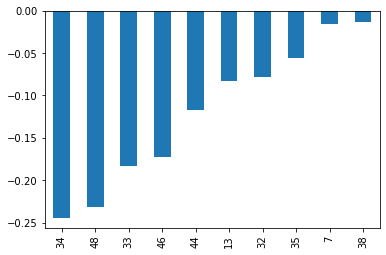

In [50]:
df_total["Variacion"] = (df_total["Nueva_Prod"] / df_total["Producción Total"]) - 1
df_total["Variacion"].sort_values()[:10].plot(kind="bar")

In [80]:
df_total["Cambio_Prod"] = df_total["Nueva_Prod"] - df_total["Producción Total"]
df_total.iloc[34]

Consumo Doméstico (pb)                 213445.000000
Importaciones (pb)                      48245.000000
Total Consumo (pb)                     261690.000000
Impuestos netos sobre productos          6819.000000
Total Consumo (pc)                     268509.000000
Valor Agregado Bruto                   174429.000000
Remuneraciones                          77269.000000
Impuestos netos sobre la producción      3763.000000
EBE / IMB                               93397.000000
Producción Total                       442938.000000
Empleo Total                            38347.000000
Demanda Final                          323514.000000
Nueva_Prod                             334823.940645
Cambio_Prod                           -108114.059355
Name: 34, dtype: float64

In [57]:
df_total["Variacion"].sort_values()[:10]

34   -0.244084
48   -0.231375
33   -0.183064
46   -0.172117
44   -0.117634
13   -0.082701
32   -0.077831
35   -0.056295
7    -0.016356
38   -0.013673
Name: Variacion, dtype: float64

In [81]:
df_sector.iloc[34]

nombresector    Fabricación de cuero, productos de cuero y cal...
ones                                                            1
salesgrowth                                             -0.287831
p0                                                       0.712169
Name: 34, dtype: object

In [38]:
df_sales[["nombresector", "salesgrowth"]].iloc[:6]

,nombresector,salesgrowth
0,"Fabricación de cuero, productos de cuero y cal...",-0.287831
1,Fabricación de muebles,-0.245327
2,Fabricación de maquinaria y equipo,-0.235891
3,Fabricación de metales comunes,-0.221665
4,"Fabricación de cemento, artículos de hormigón ...",-0.218211
5,Fabricación de prendas de vestir,-0.216469


In [98]:
import networkx as nx
W = np.array(df_mct)
G = nx.from_numpy_matrix(W, create_using=nx.DiGraph())
pd.DataFrame([(k,v) for k,v in nx.degree_centrality(G).items()]).sort_values(by=1, ascending=False)

,0,1
56,56,1.800000
25,25,1.685714
69,69,1.671429
52,52,1.671429
46,46,1.628571
...,...,...
14,14,0.514286
7,7,0.442857
66,66,0.385714
31,31,0.385714


In [105]:
pd.DataFrame([(k,v) for k,v in nx.eigenvector_centrality(G).items()]).sort_values(by=1, ascending=False)

,0,1
23,23,1.654783e-01
26,26,1.631842e-01
56,56,1.600197e-01
15,15,1.597695e-01
35,35,1.595183e-01
...,...,...
5,5,5.993363e-02
58,58,5.807148e-02
3,3,5.467538e-02
7,7,4.963068e-02


In [107]:
df_sector.iloc[26]

nombresector    Elaboración de alimentos preparados para animales
ones                                                            1
salesgrowth                                                     0
p0                                                              1
Name: 26, dtype: object

In [ ]:
shock_1 = "degree_centrality"
shock_2 = "eigenvector_centrality"
shock_3 = "sector_clave"
shock_4 = "sector_motor"

drop_1 = "marzo_sri"
drop_2 = "abril_sri"

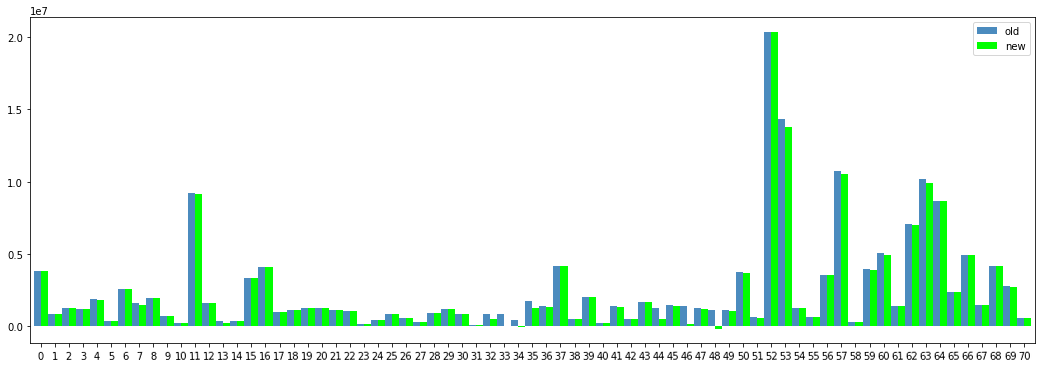

In [11]:
list_of_tuples = list(zip(df_total["Producción Total"], df_total["Nueva_Prod"]))
new_df = pd.DataFrame(list_of_tuples, index = df_total["Producción Total"].index, columns = ['old', 'new'])
new_df.plot(kind='bar'
                                  , figsize=(18,6)
                                  , width=1
                                  , color=['#4b8bbe','lime','red']
                                  , rot=2)

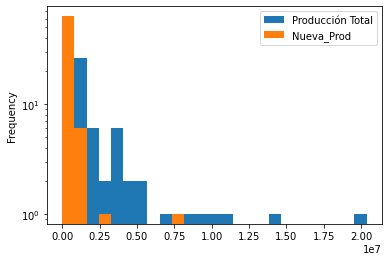

In [24]:
df_total[["Producción Total", "Nueva_Prod"]].plot(kind="hist", bins=25, logy=True)


In [12]:
df_total.columns

Index(['Consumo Doméstico (pb)', 'Importaciones (pb)', 'Total Consumo (pb)',
       'Impuestos netos sobre productos', 'Total Consumo (pc)',
       'Valor Agregado Bruto', 'Remuneraciones',
       'Impuestos netos sobre la producción', 'EBE / IMB', 'Producción Total',
       'Empleo Total', 'Demanda Final'],
      dtype='object')

In [9]:
df_total['Total Consumo (pc)'] + df_total['Valor Agregado Bruto']

0     3833513
1      821683
2     1229466
3     1157014
4     1840142
       ...   
66    4937334
67    1420075
68    4141983
69    2734612
70     548343
Length: 71, dtype: int64